In [2]:
import torch
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import anndata as ad
import harmonypy as hm
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA
import iSp3D as MODEL
from iSp3D import Func
from iSp3D import Metrics

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI

c:\Users\CLEARLOVE\.conda\envs\STG\lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
c:\Users\CLEARLOVE\.conda\envs\STG\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
c:\Users\CLEARLOVE\.conda\envs\STG\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
c:\Users\CLEARLOVE\.conda\envs\STG\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
c:\Users\CLEARLOVE\.conda\envs\ST

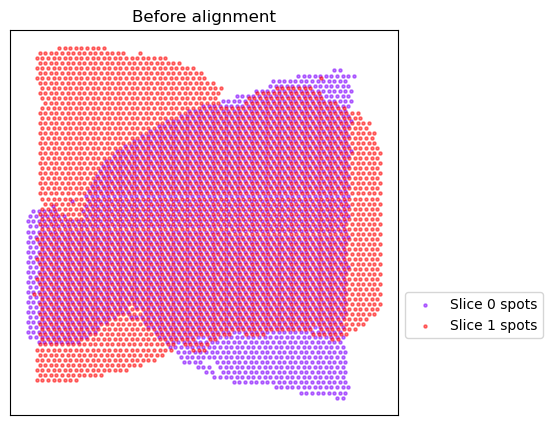

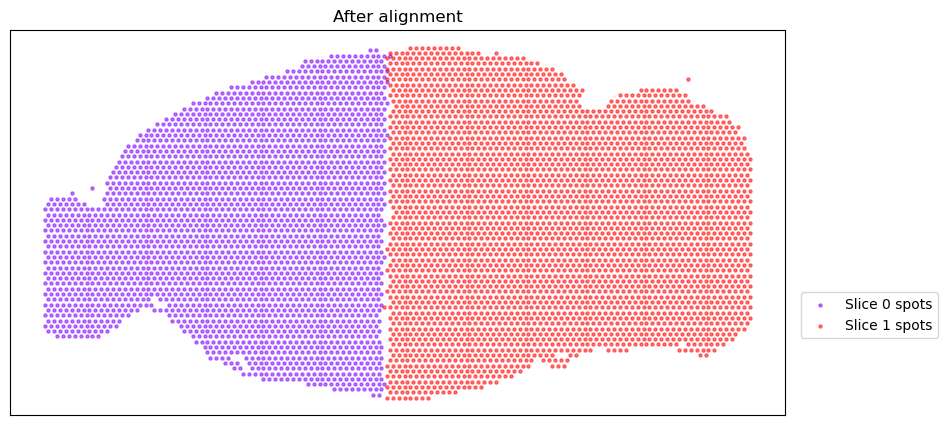

In [ ]:
ROOT_PATH = Path(r'C:\Code\Data\ST Adult mouse brain section A\MBA-MBP')
DATA_NAME = 'Mouse_Brain_Anterior'
adata_anterior = sc.read_visium(ROOT_PATH / DATA_NAME, count_file=DATA_NAME + "_filtered_feature_bc_matrix.h5")
adata_anterior.var_names_make_unique()

spatial_a=pd.read_csv(r"C:\Code\Data\ST Adult mouse brain section A\MBA-MBP/Mouse_Brain_Anterior/spatial/tissue_positions_list.csv",
                    sep=",",header=None,na_filter=False,index_col=0)
adata_anterior.obs["x_array"]=spatial_a[2]
adata_anterior.obs["y_array"]=spatial_a[3]
adata_anterior.obs["x_pixel"]=spatial_a[4]
adata_anterior.obs["y_pixel"]=spatial_a[5]
adata_anterior.obs['boundary'] = 0
# adata_anterior.obs['x_pixel'] = adata_anterior.obsm['spatial'][:,0]
# adata_anterior.obs['y_pixel'] = adata_anterior.obsm['spatial'][:,1]
# make spot name unique
adata_anterior.obs_names = [x + '_anterior' for x in adata_anterior.obs_names]

DATA_NAME = 'Mouse_Brain_Posterior'
adata_posterior = sc.read_visium(ROOT_PATH / DATA_NAME, count_file=DATA_NAME + "_filtered_feature_bc_matrix.h5")
adata_posterior.var_names_make_unique()

spatial_p=pd.read_csv(r"C:\Code\Data\ST Adult mouse brain section A\MBA-MBP/Mouse_Brain_Posterior/spatial/tissue_positions_list.csv",
                    sep=",",header=None,na_filter=False,index_col=0)
adata_posterior.obs["x_array"]=spatial_p[2]
adata_posterior.obs["y_array"]=spatial_p[3]
adata_posterior.obs["x_pixel"]=spatial_p[4]
adata_posterior.obs["y_pixel"]=spatial_p[5]
adata_posterior.obs['boundary'] = 0
# adata_posterior.obs['x_pixel'] = adata_posterior.obsm['spatial'][:,0]
# adata_posterior.obs['y_pixel'] = adata_posterior.obsm['spatial'][:,1]
# make spot name unique
adata_posterior.obs_names = [x + '_posterior' for x in adata_posterior.obs_names]

obs_a = adata_anterior.obs
obs_p = adata_posterior.obs
# obs_p["x_pixel"]=obs_p["x_pixel"]-np.min(obs_p["x_pixel"])+np.min(obs_a["x_pixel"])
obs_p["y_pixel"] = obs_p["y_pixel"] - np.min(obs_p["y_pixel"]) + np.max(obs_a["y_pixel"]) - 150
# obs_p["y_pixel"] = obs_p["y_pixel"] - np.min(obs_p["y_pixel"]) + np.max(obs_a["y_pixel"]) + 1500

obs_a["boundary"] = 0
obs_p["boundary"] = 0

for i in list(set(obs_a['x_array'])):
    j = obs_a[obs_a['x_array'] == i].max()["y_array"]
    temp = obs_a[obs_a['x_array'] == i]
    temp = temp[temp['y_array'] == j].index
    obs_a.loc[temp, "boundary"] = 1

for i in list(set(obs_p['x_array'])):
    j = obs_p[obs_p['x_array'] == i].min()["y_array"]
    temp = obs_p[obs_p['x_array'] == i]
    temp = temp[temp['y_array'] == j].index
    obs_p.loc[temp, "boundary"] = 1

mean_a_y = obs_a[obs_a["boundary"] == 1]['x_pixel'].mean()
mean_p_y = obs_p[obs_p["boundary"] == 1]['x_pixel'].mean()
obs_p['x_pixel'] = obs_p['x_pixel'] + mean_a_y - mean_p_y

adata_anterior.obsm["spatial_aligned"] = adata_anterior.obs.loc[adata_anterior.obs_names, ['x_pixel', "y_pixel"]].to_numpy()
adata_posterior.obsm["spatial_aligned"] = adata_posterior.obs.loc[adata_posterior.obs_names, ['x_pixel', "y_pixel"]].to_numpy()

list_adata = [adata_anterior, adata_posterior]

plot = True
coor_key = "spatial"
if plot:
    from matplotlib import cm
    import matplotlib
    import matplotlib.pyplot as plt

    # Choose colors
    cmap = cm.get_cmap('rainbow', len(list_adata))
    colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(list_adata))]

    # Plot spots before alignment
    plt.figure(figsize=(5, 5))
    plt.title("Before alignment")
    for i in range(len(list_adata)):
        plt.scatter(list_adata[i].obsm[coor_key][:, 0],
                    list_adata[i].obsm[coor_key][:, 1],
                    c=colors_list[i],
                    label="Slice %d spots" % i, s=5., alpha=0.5)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc=(1.02, .2), ncol=(len(list_adata) // 13 + 1))
    plt.show()

if plot:
    plt.figure(figsize=(10, 5))
    plt.title("After alignment")
    for i in range(len(list_adata)):
        plt.scatter(list_adata[i].obsm["spatial_aligned"][:, 1],
                    list_adata[i].obsm["spatial_aligned"][:, 0],
                    c=colors_list[i],
                    label="Slice %d spots" % i, s=5., alpha=0.5)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc=(1.02, .2), ncol=(len(list_adata) // 13 + 1))
    plt.show()

import anndata as ad
pre_adata = ad.concat(list_adata, label="batch_name", keys=['anterior', 'posterior'])
pre_adata.obs["batch_name"] = pre_adata.obs["batch_name"].astype('category')
slice_name_list = list(pre_adata.obs['batch_name'].unique())

with open(r"C:\Code\iSpa3D\Config\Config_SMB.yaml", 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [4]:
result, mapping = mapping2int(slice_name_list)

for i, proj_name in enumerate(slice_name_list):

    adata_tmp = pre_adata[pre_adata.obs['batch_name'] == slice_name_list[i]]
    adata_tmp.obs['slice_id'] = mapping[proj_name]
    graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['data']['k_cutoff'])

    ##### Load layer_guess label, if have
    # df_label = pd.read_csv(data_root / proj_name / 'manual_annotations.txt', sep='\t', header=None, index_col=0)
    # df_label.columns = ['layer_guess']
    # adata_tmp.obs['layer_guess'] = df_label['layer_guess']
    #adata_tmp= adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

    if proj_name == slice_name_list[0]:
        adata = adata_tmp
        graph_dict = graph_dict_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name

        adata = adata.concatenate(adata_tmp)
        graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
        name = name + '_' + proj_name

adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['data']['top_genes'])
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable.
adata.obsm['X_original'] = adata.X.copy()
pca = PCA(n_components=200, random_state=42)
adata_X = pca.fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

num_cluster = config['model']['class_num']
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

method = 'mclust'
net.train()

def inverse_pca_transform(pca, recon_pca_data):
    recon_original = pca.inverse_transform(recon_pca_data)
    return recon_original

enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon)
adata.obsm['X_reconstructed'] = recon_original

print(adata)

Epoch 295 total loss=4.457 recon loss=0.408 tri loss=0.000 disc loss=0.442 cluster loss=4.143:  50%|████▉     | 299/600 [00:10<00:10, 28.84it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 345 total loss=4.477 recon loss=0.389 tri loss=0.168 disc loss=0.454 cluster loss=4.121:  58%|█████▊    | 349/600 [00:23<00:15, 15.82it/s]

fitting ...
  |======================================================================| 100%


Epoch 395 total loss=4.378 recon loss=0.385 tri loss=0.146 disc loss=0.458 cluster loss=4.018:  67%|██████▋   | 400/600 [00:57<00:12, 15.95it/s]

fitting ...
  |======================================================================| 100%


Epoch 445 total loss=4.245 recon loss=0.395 tri loss=0.140 disc loss=0.452 cluster loss=3.884:  75%|███████▍  | 449/600 [01:13<00:09, 16.45it/s]

fitting ...
  |======================================================================| 100%


Epoch 495 total loss=4.185 recon loss=0.370 tri loss=0.112 disc loss=0.447 cluster loss=3.838:  83%|████████▎ | 499/600 [01:27<00:06, 16.35it/s]

fitting ...
  |======================================================================| 100%


Epoch 545 total loss=4.116 recon loss=0.390 tri loss=0.101 disc loss=0.436 cluster loss=3.773:  92%|█████████▏| 550/600 [01:44<00:03, 16.31it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=4.090 recon loss=0.384 tri loss=0.105 disc loss=0.440 cluster loss=3.742: 100%|██████████| 600/600 [02:00<00:00,  5.00it/s]

AnnData object with n_obs × n_vars = 6050 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'boundary', 'batch_name', 'slice_id', 'proj_name', 'batch', 'Tmp_domain'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'spatial_aligned', 'X_original', 'X_pca', 'latent', 'recon', 'X_reconstructed'
    layers: 'count'


fitting ...
  |======================================================================| 100%
total ARI:0.4654047608039119


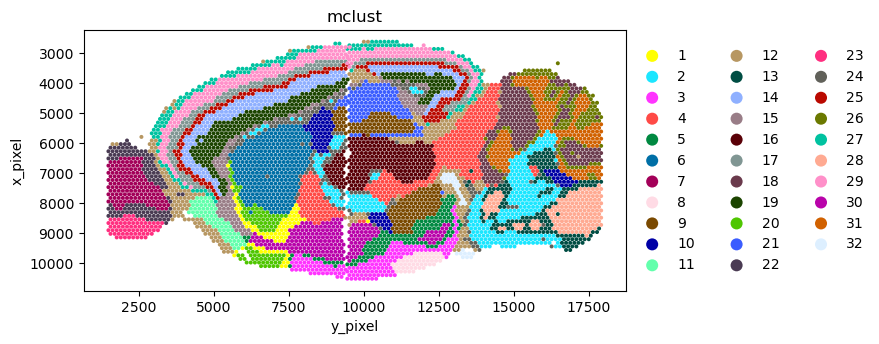

In [7]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

adata1 = adata[adata.obs['batch_name'] == 'anterior']
df_label = pd.read_csv(r'C:\Code\Data\ST Adult mouse brain section A/MBA-MBP/Mouse_Brain_Anterior/Manual_annotations.tsv', sep='\t',  index_col=0)
#转换index名称
index = [s + '_anterior-0' for s in df_label.index]
df_label.index = index
adata1.obs["layer_guess"] = df_label['ground_truth']

sub_adata = adata1[~pd.isnull(adata1.obs['layer_guess'])]

ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")

import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色

subadata = adata[~adata.obs['mclust'].isna()]  # 删除 NaN
ax=sc.pl.scatter(subadata,alpha=1,x="y_pixel",y="x_pixel",color="mclust",show=False,size=200000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.grid(False)

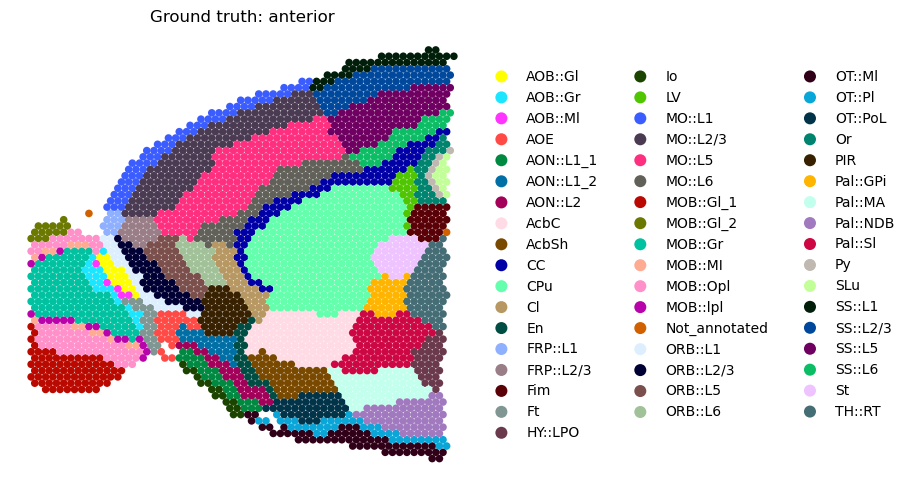

In [8]:
import matplotlib.pyplot as plt

# visualize manual ground truth labels on anterior slice
sub_gt = adata1[~adata1.obs['layer_guess'].isna()].copy()
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.scatter(
    sub_gt,
    x="y_pixel",
    y="x_pixel",
    color="layer_guess",
    show=False,
    size=120,
    alpha=1,
    ax=ax,
)
ax.set_aspect('equal', 'box')
ax.invert_yaxis()
ax.axis('off')
plt.title("Ground truth: anterior")
# plt.savefig('ground_truth_anterior.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

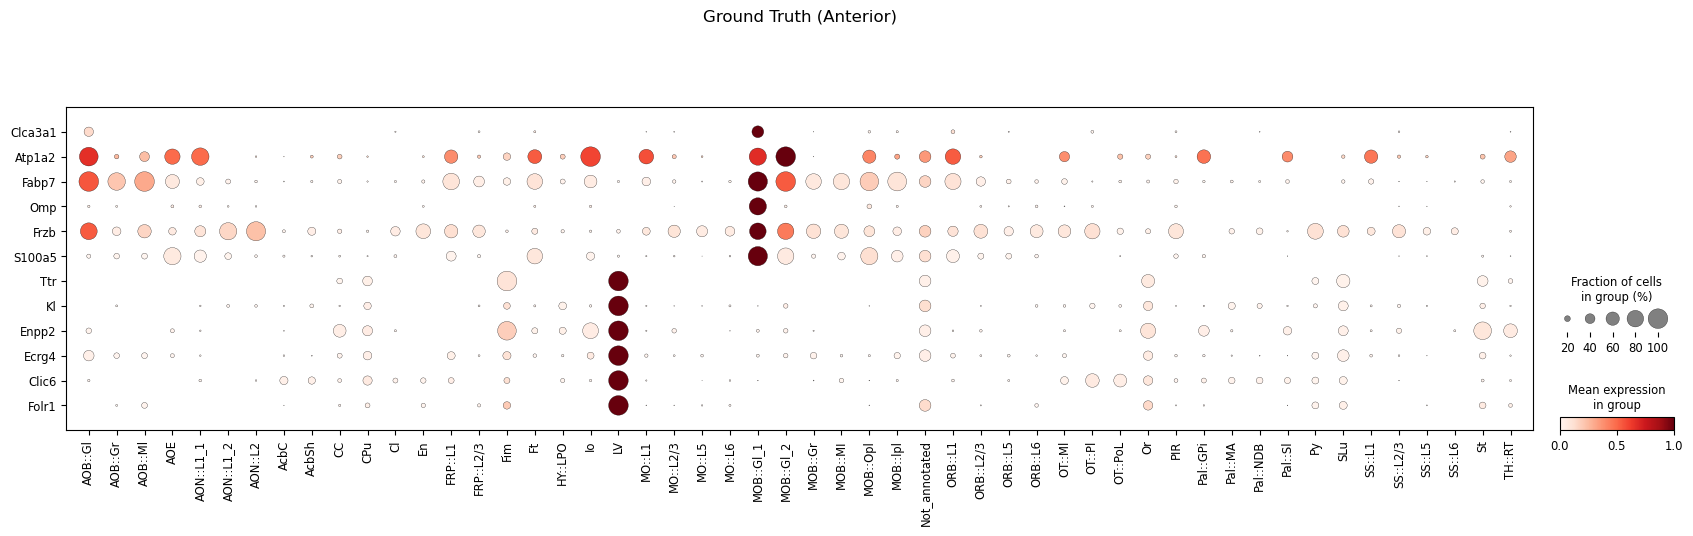

In [8]:
# 绘制 adata1 ground_truth 的气泡图
dg = ['Clca3a1', 'Atp1a2', 'Fabp7', 'Omp', 'Frzb', 'S100a5', 'Ttr', 'Kl', 'Enpp2', 'Ecrg4', 'Clic6', 'Folr1']
sub_adata1 = adata1[~adata1.obs['layer_guess'].isna()].copy()
sc.pl.dotplot(sub_adata1, dg, groupby='layer_guess', dendrogram=None, swap_axes=True, standard_scale='var', title='Ground Truth (Anterior)', show=False)
plt.savefig('ground_truth_dotplot.pdf', bbox_inches='tight')
plt.show()

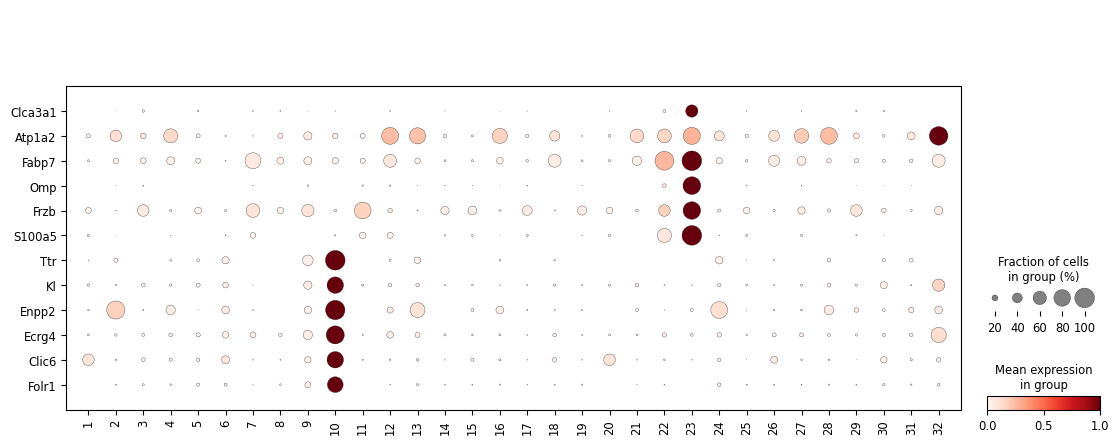

In [10]:
adata = sc.read(r"C:\Code\Answer\MBA_MBP\OURS.h5ad")

adata.obs['re_mclust'] = adata.obs['mclust'].astype(str)
# ['Ttr', 'Kl', 'Enpp2', 'F5', 'Ecrg4', 'Clic6', 'Folr1']
dg = ['Clca3a1', 'Atp1a2', 'Fabp7', 'Omp', 'Frzb', 'S100a5', 'Ttr', 'Kl', 'Enpp2', 'Ecrg4', 'Clic6', 'Folr1']
sc.pl.dotplot(adata, dg, groupby='re_mclust', dendrogram=None, swap_axes=True, standard_scale='var', show=False)
plt.savefig('mclust_dotplot.pdf', bbox_inches='tight')
plt.show()